In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary
from comet_ml import Experiment
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from DANet import CAM
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace

# Setting the seed for reproducibility
torch.manual_seed(42)


In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": weights_small.IMAGENET1K_V1,
    "module": CAM,
    "module_alias": "CAM",
    "data_path": "/Users/leo/Desktop/Thesis/data/faces_50/",
    "batch_size": 16,
    "img_size": 64,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "manual_block_insertion": [11],
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/6b9fec5c524b4a6db7aaf1f01566cdd1



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


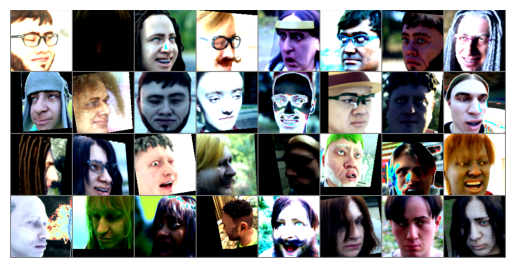

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(prms["manual_block_insertion"]), prms["model_save_path"]) if prms["load_model"] else model.build(prms["manual_block_insertion"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

# log loss and optimizer
prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer})

<class 'DANet.CAM'> inserted in the following layers: [11]
Weights initialized for <class 'DANet.CAM'> inserted in the following layers: [11] as well as the last layer.
Grads set to True for [11] and the last layer. (False for the rest)


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 64, 64]       [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                                      [1, 3, 64, 64]       [1, 576, 2, 2]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 64, 64]       [1, 16, 32, 32]      --                   --                   --                   False
│    │    └─Conv2d (0)                                       [1, 3, 64, 64]       [1, 16, 32, 32]      (432)                [3, 3]               442,368              False
│    │    └─BatchNorm2d (1)                                  [1, 16, 32, 32]      [1, 16, 32, 32]      (32)                 --      

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

  0%|          | 0/90 [00:00<?, ?it/s]/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)
100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epoch: 01 | Epoch Time: 0.0m 24s
	Train Loss: 3.163 | Train Acc: 27.96%
	 Val. Loss: 2.268 |  Val. Acc: 48.18%
Best Accuracy Achieved: 48.18% on epoch 01


100%|██████████| 18/18 [00:02<00:00,  8.51it/s]


Epoch: 02 | Epoch Time: 0.0m 20s
	Train Loss: 1.602 | Train Acc: 62.63%
	 Val. Loss: 1.200 |  Val. Acc: 67.64%
Best Accuracy Achieved: 67.64% on epoch 02


100%|██████████| 18/18 [00:02<00:00,  8.95it/s]


Epoch: 03 | Epoch Time: 0.0m 20s
	Train Loss: 0.964 | Train Acc: 76.91%
	 Val. Loss: 0.888 |  Val. Acc: 76.55%
Best Accuracy Achieved: 76.55% on epoch 03


100%|██████████| 18/18 [00:02<00:00,  8.86it/s]


Epoch: 04 | Epoch Time: 0.0m 20s
	Train Loss: 0.749 | Train Acc: 80.74%
	 Val. Loss: 0.830 |  Val. Acc: 77.45%
Best Accuracy Achieved: 77.45% on epoch 04


100%|██████████| 18/18 [00:01<00:00,  9.06it/s]


Epoch: 05 | Epoch Time: 0.0m 20s
	Train Loss: 0.628 | Train Acc: 84.00%
	 Val. Loss: 0.719 |  Val. Acc: 80.73%
Best Accuracy Achieved: 80.73% on epoch 05


100%|██████████| 18/18 [00:02<00:00,  8.42it/s]


Epoch: 06 | Epoch Time: 0.0m 20s
	Train Loss: 0.541 | Train Acc: 86.70%
	 Val. Loss: 0.706 |  Val. Acc: 79.64%


100%|██████████| 18/18 [00:02<00:00,  8.84it/s]


Epoch: 07 | Epoch Time: 0.0m 20s
	Train Loss: 0.473 | Train Acc: 87.93%
	 Val. Loss: 0.710 |  Val. Acc: 79.82%


100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


Epoch: 08 | Epoch Time: 0.0m 19s
	Train Loss: 0.430 | Train Acc: 89.44%
	 Val. Loss: 0.667 |  Val. Acc: 80.18%


100%|██████████| 18/18 [00:01<00:00,  9.41it/s]


Epoch: 09 | Epoch Time: 0.0m 19s
	Train Loss: 0.411 | Train Acc: 89.75%
	 Val. Loss: 0.647 |  Val. Acc: 81.09%
Best Accuracy Achieved: 81.09% on epoch 09


100%|██████████| 18/18 [00:01<00:00,  9.48it/s]


Epoch: 10 | Epoch Time: 0.0m 18s
	Train Loss: 0.367 | Train Acc: 90.63%
	 Val. Loss: 0.630 |  Val. Acc: 81.09%


100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Epoch: 11 | Epoch Time: 0.0m 19s
	Train Loss: 0.340 | Train Acc: 91.79%
	 Val. Loss: 0.635 |  Val. Acc: 81.27%
Best Accuracy Achieved: 81.27% on epoch 11


100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


Epoch: 12 | Epoch Time: 0.0m 20s
	Train Loss: 0.354 | Train Acc: 91.23%
	 Val. Loss: 0.587 |  Val. Acc: 83.27%
Best Accuracy Achieved: 83.27% on epoch 12


  1%|          | 1/90 [00:00<00:21,  4.20it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/6e1c6da0392b497cb41cadfab2333b63
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.006853570938110351
COMET INFO:     test_accuracy   : 0.4050000011920929
COMET INFO:     test_loss       : 2.2474740409851073
COMET INFO:     train_acc [50]  : (0.06421052664518356, 0.4828070402145386)
COMET INFO:     train_loss [50] : (1.9780368540579814, 3.990018710755465)
COMET INFO:     val_acc [50]    : (0.03272727131843567, 0.4145454466342926)
COMET INFO:     val_loss [50]   : (2.3432380403171886, 4.290506003986706)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobilenet_v3_small at 0x1454c0040>
COMET INFO:     batch_size      : 16
COMET INFO:     data_path       : /U

Test loss: 2.247.. 
Test accuracy: 0.405
Test Time: 0.0m 1s 370ms


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


(2.2474740409851073, tensor(0.4050, device='mps:0'))